# 🛠️ Facies Classification with SVM

This workflow outlines the steps to **explore, condition, train, and apply** a Support Vector Machine (SVM) classifier for facies prediction using well-log data.

---

## 1. 📂 Data Exploration
- Load the training dataset from **9 wells**.  
- Visualize log data for a couple of wells.  
- Generate **cross plots** to examine feature variation across facies.  

✅ *Goal:* Understand the structure, completeness, and variability of the dataset.  

---

## 2. 🧹 Data Conditioning
- Remove records with **incomplete data**.  
- Apply **scaling** (zero mean & unit variance) to normalize logs.  
- Split dataset into:
  - **Training set**
  - **Test set**  

✅ *Goal:* Prepare clean and standardized data for SVM training.  

---

## 3. 🤖 Model Building – SVM Classifier
- Implement an **SVM classifier**.  
- Use a **cross-validation set** to tune hyperparameters:
  - `C` (regularization strength)  
  - `γ` (kernel coefficient)  
  - Kernel type (`rbf`, `linear`, etc.)  

✅ *Goal:* Build and optimize the classifier for robust facies prediction.  

---

## 4. 🧪 Model Application
- Apply the **trained and tuned model** to classify facies in wells without labels.  
- Test the workflow on **two wells**, but the approach generalizes to any number of wells with log data.  

✅ *Goal:* Predict facies distribution for unlabelled wells.  

---

## 🔑 Summary
1. **Explore** → Plot logs & cross-plots.  
2. **Condition** → Clean & scale data, split into train/test.  
3. **Build** → Train SVM with cross-validation tuning.  
4. **Apply** → Classify facies in unseen wells.  

---


# 🗂️ Facies Classes & Adjacency

Below is the facies classification scheme used in the dataset.  
The **Adjacent Facies** column highlights geologically similar facies where misclassification is most likely.

| Facies | Label | Adjacent Facies |
|--------|-------|-----------------|
| **1**  | SS (Sandstone)           | 2 |
| **2**  | CSiS (Coarse Siltstone)  | 1, 3 |
| **3**  | FSiS (Fine Siltstone)    | 2 |
| **4**  | SiSh (Silty Shale)       | 5 |
| **5**  | MS (Mudstone)            | 4, 6 |
| **6**  | WS (Wackestone)          | 5, 7 |
| **7**  | D (Dolomite)             | 6, 8 |
| **8**  | PS (Packstone)           | 6, 7, 9 |
| **9**  | BS (Boundstone)          | 7, 8 |

---

## 🔑 Notes
- Neighboring facies (e.g., **2 ↔ 3**) may **blend gradually** rather than forming sharp boundaries.  
- Misclassification between adjacent facies is expected and should not be treated as a hard error.  
- This adjacency mapping can also be incorporated into **custom evaluation metrics** (e.g., penalize less when misclassification happens between adjacent facies).  


In [3]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None
import seaborn as sns
%config InlineBackend.figure_format = 'retina'



In [11]:
#data=pd.read_csv('../../data/final-data.csv')
data=pd.read_csv('../../data/input_pilot_data.csv')
training_data=data.copy()
training_data.head()


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


The dataset contains the following well-log measurements and derived features, used as predictors for facies classification:

| Feature    | Description |
|------------|-------------|
| **GR**     | Gamma Ray log. Measures natural gamma emission from the formation. A good index for **shale content**. |
| **ILD_log10** | Log-transformed deep resistivity measurement. Useful for identifying **reservoir fluid content**. |
| **PE**     | Photoelectric effect log. Helps identify **lithology / mineral composition** of the rock. |
| **DeltaPHI** | Difference between neutron porosity (PHIN) and density porosity (PHID). Indicates **porosity variations** and gas effects. |
| **PNHIND** | Average of neutron and density porosity logs. Provides a **smoothed porosity index**. |
| **NM_M**   | Non-marine vs. marine environment indicator. Relates to **depositional environment**. |
| **RELPOS** | Relative stratigraphic position within the depositional unit. Captures **geological context**. |

---

##  Notes
- **GR, ILD, PE** → Fundamental petrophysical logs (shale, fluids, lithology).  
- **DeltaPHI, PNHIND** → Derived porosity indicators.  
- **NM_M, RELPOS** → Non-log geological context features.  
- Together, these features provide both **petrophysical** and **stratigraphic/depositional context** for facies classification.  


In [12]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()



['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

### let's define a color map so the facies are represented by consistent color in all the plots in this 

In [13]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


### Looking at the count values, most values have 4149 valid values except for PE, which has 3232. In this script we will drop the feature vectors that don't have a valid PE entry.


In [16]:
PE_mask=training_data['PE'].notna()
training_data=training_data[PE_mask]
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


### Keep a single well to use as a blind test later.


In [24]:
blind_well = training_data[training_data['Well Name']=='SHRIMPLIN']
training_data = training_data[training_data['Well Name']!='SHRIMPLIN']
print(f"These are the well after keep a blind well:\n ",training_data['Well Name'].unique())


These are the well after keep a blind well:
  ['SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']


In [25]:
training_data.shape

(2761, 12)

In [26]:
#I changed the colors to match the paper for easier compare.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

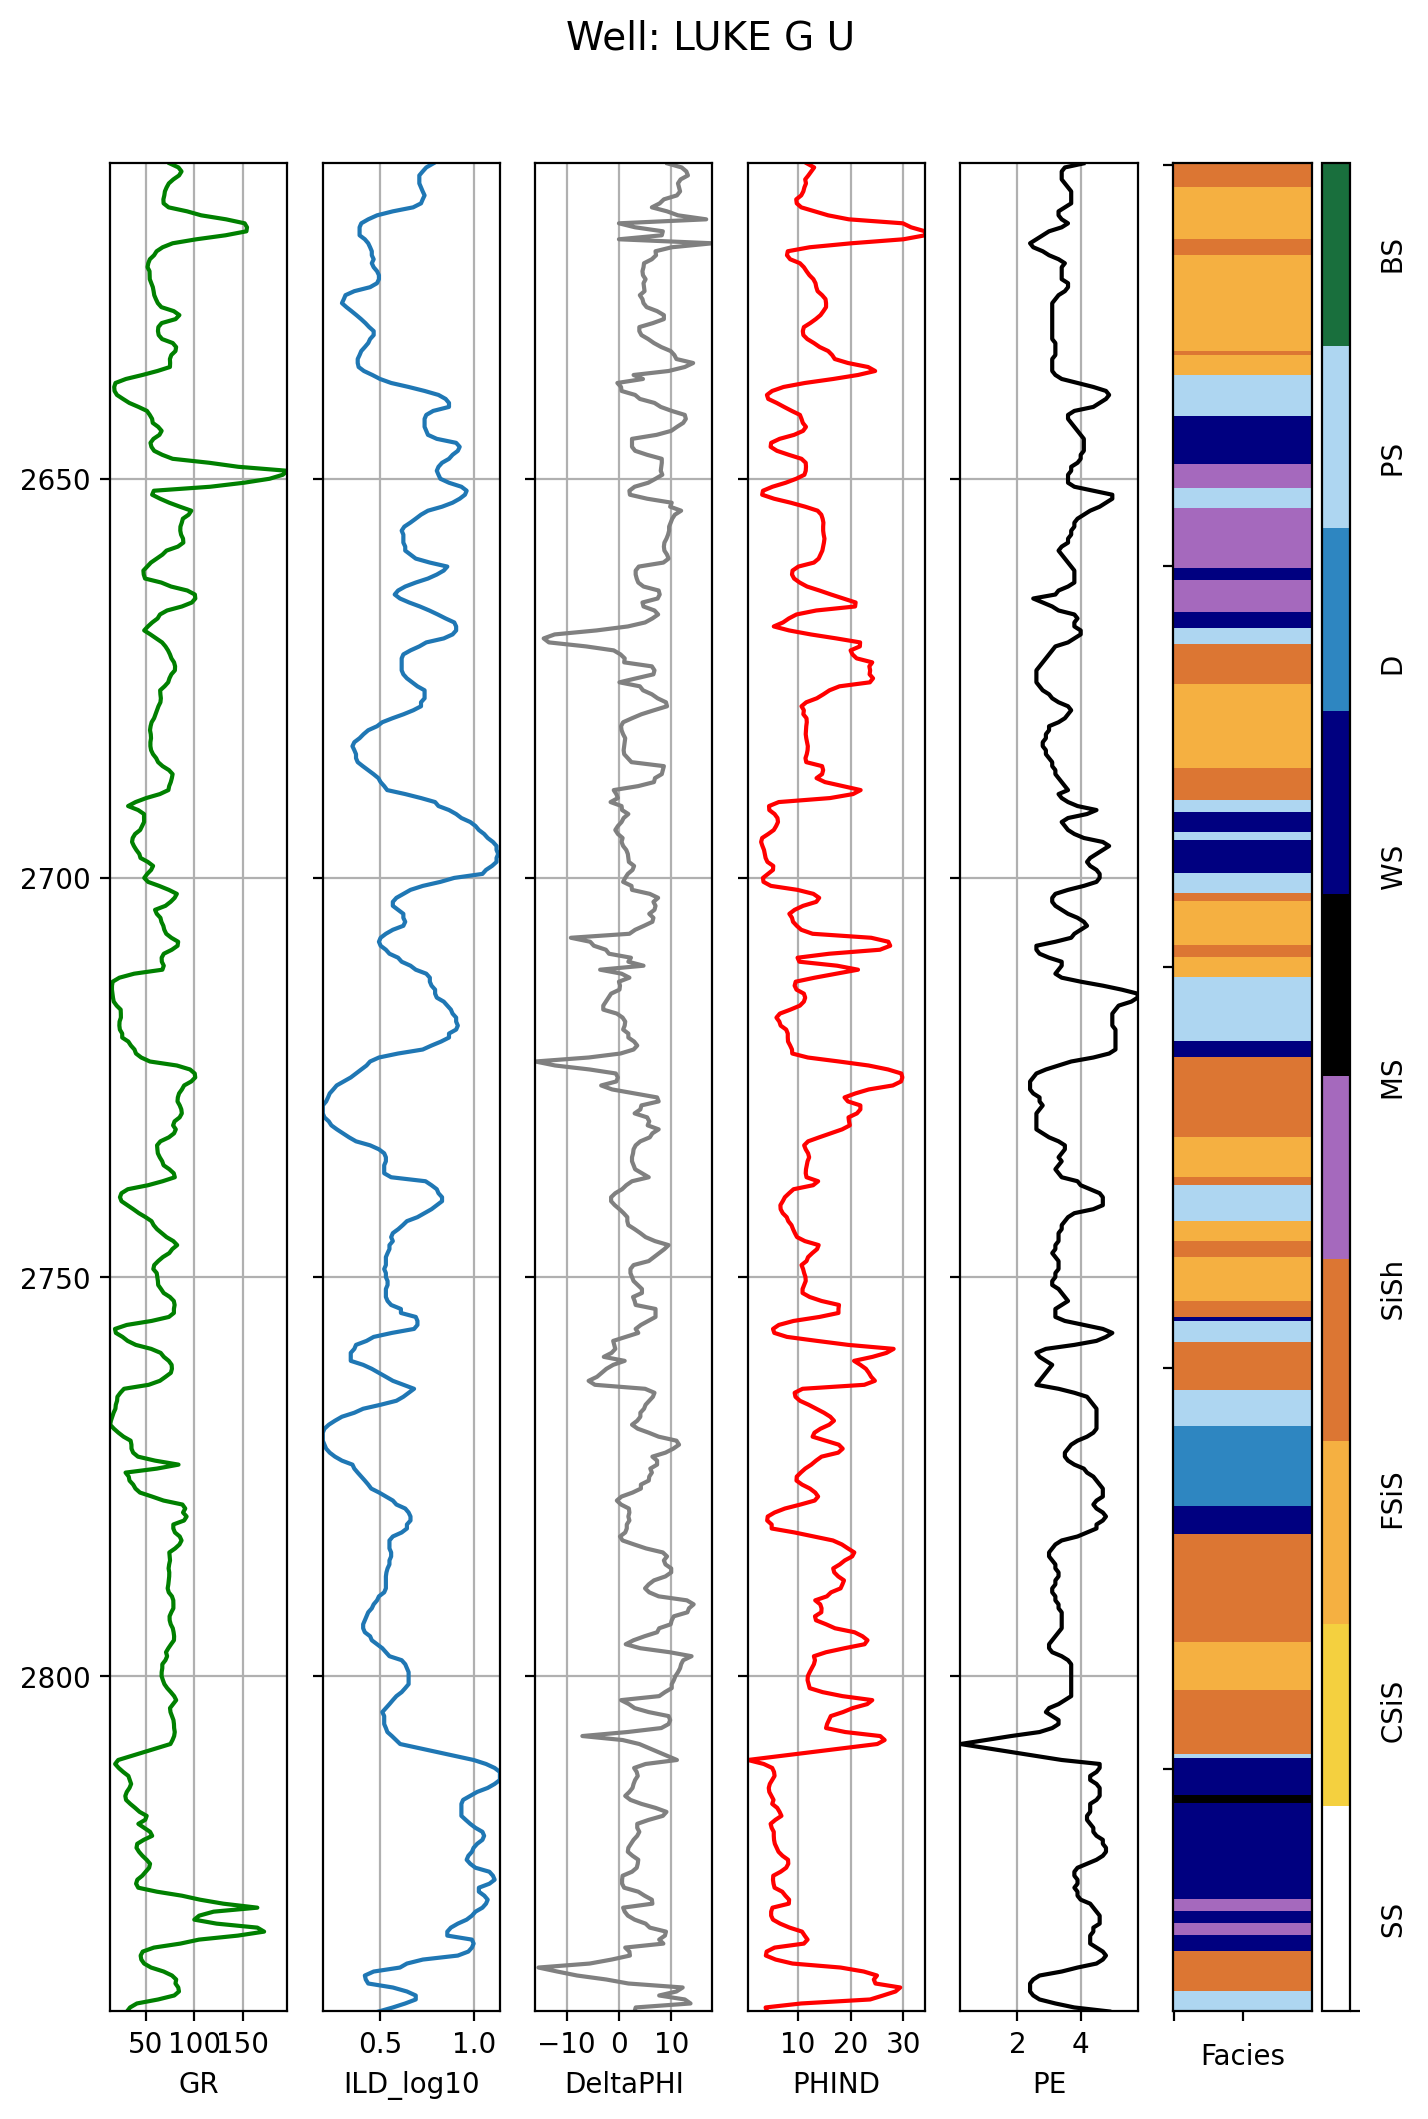

In [29]:
make_facies_log_plot(training_data[training_data['Well Name']=='LUKE G U'], facies_colors)

<Axes: title={'center': 'Distribution of Training Data by Facies'}>

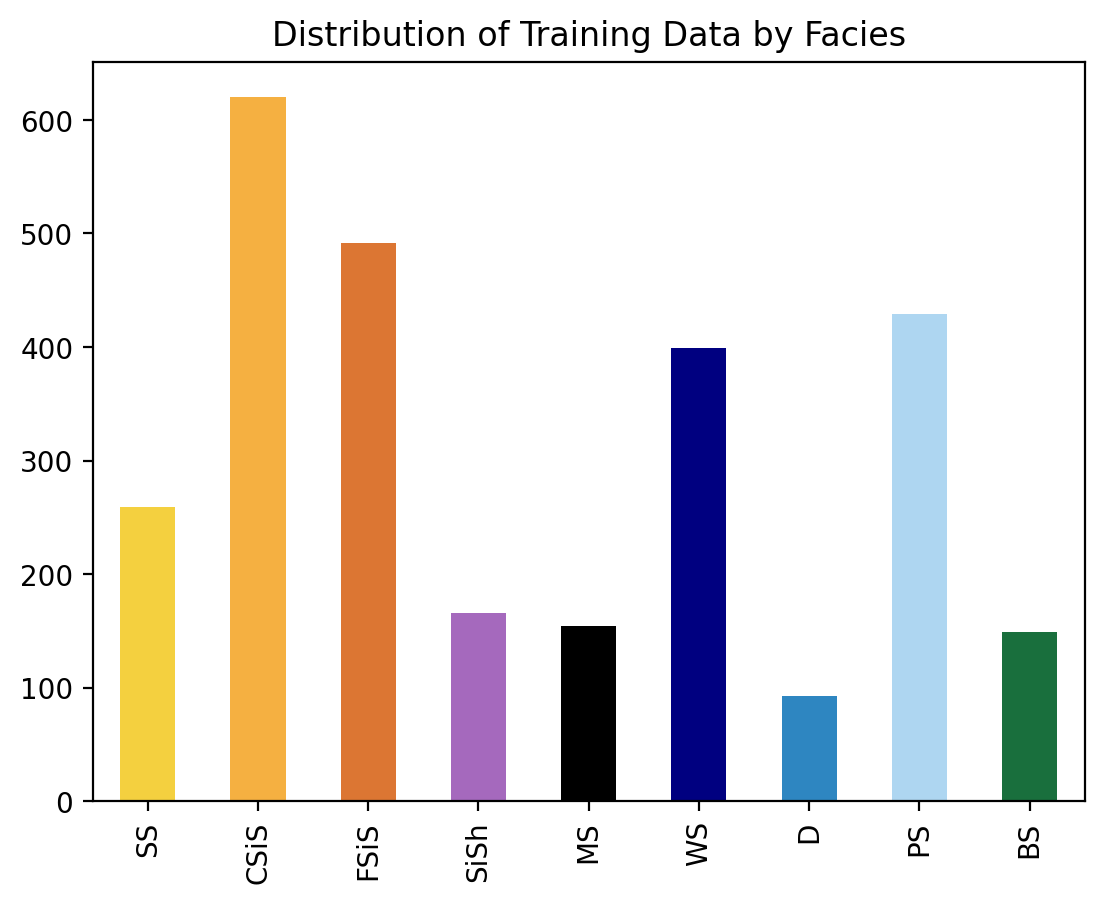

In [30]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)


facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

#light_rgb = colors.ListedColormap(facies_colors)
facies_counts.plot(kind='bar',color=facies_colors, 
                   
                   title='Distribution of Training Data by Facies')



## Cross plot: Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.

In [ ]:
inline_rc=dict(mpl.rcParams) #grab current rc settings
mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['font.size'] = 14
sns.set_style("whitegrid")
pairplot=sns.pairplot(training_data.drop["Well Name","Facies","Formation"], hue='FaciesLabels', 
                      vars=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE'],
                      palette=facies_color_map, diag_kind='hist',
                      plot_kws = {'alpha':0.5, 's':15, 'edgecolor':'k'},
                      diag_kws = {'edgecolor':'k', 'bins':25},
                      hue_order=list(reversed(facies_labels)))
mpl.rcParams.update(inline_rc)




# 
Conditioning the data set

Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.


In [31]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()


,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000
mean,65.577405,0.639826,2.851888,13.706603,3.640581,1.500181,0.521278
std,29.587629,0.243261,5.044868,8.014523,0.867410,0.500091,0.286324
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.923000,0.493000,0.800000,8.412000,3.084000,1.000000,0.276000
50%,65.360000,0.627366,2.991000,12.128000,3.500000,2.000000,0.528000
75%,78.820000,0.810000,5.800000,16.710000,4.200000,2.000000,0.768000
max,305.870000,1.311000,18.600000,84.400000,8.094000,2.000000,1.000000


In [20]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)



ValueError: could not convert string to float: 'Original'

In [21]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)



NameError: name 'scaled_features' is not defined

# Training the SVM classifier


In [ ]:


from sklearn import svm

clf = svm.LinearSVC(random_state=42) 



## SVM Grid seacrh

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# # param_grid = {'svc__C': [1, 5, 10, 50],
# #               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# # grid = GridSearchCV(clf, param_grid)

# # %time grid.fit(X_train, y_train)
# # print(grid.best_params_)

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
# clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
#                    param_grid, cv=5, iid=False)
# clf = clf.fit(X_train, y_train)
# # print("done in %0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
predicted_labels = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)


In [ ]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

# Model parameter selection

In [ ]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = False

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

In [ ]:
clf = svm.LinearSVC(class_weight='balanced', tol=1e-03,C=10, random_state=42)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))


In [ ]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)



In [ ]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)


# Applying the classification model to the blind data

In [ ]:
blind

In [ ]:
y_blind = blind['Facies'].values

In [ ]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
X_blind = scaler.transform(well_features)

In [ ]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

In [ ]:
y_pred
np.save('svm_ypred',y_pred)


In [ ]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))


In [ ]:
temp=['1','2','3','4','5','6','7','8','9']

sns.heatmap(cv_conf,annot=True, center=True,fmt='d',xticklabels=temp,yticklabels=temp)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.show()


In [ ]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

In [ ]:


display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)



In [ ]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
#     print(logs)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

# 
K-fold cross validation


In [ ]:
from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold

kf = KFold(4, random_state=666)


In [ ]:
print(kf)